In [69]:
import numpy as np
import pandas as pd

In [70]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict 
from scipy import sparse
from scipy.stats import pearsonr
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import NearestNeighbors
import warnings
# !pip install cmfrec
# from cmfrec import CMF
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error

In [71]:
movies = pd.read_fwf("C:\\Users\\DELL\\Downloads\\movies.dat",encoding='ISO-8859-1',header=None)

In [72]:
users = pd.read_fwf("C:\\Users\\DELL\\Downloads\\users.dat",encoding='ISO-8859-1',header=None)

In [73]:
ratings = pd.read_fwf("C:\\Users\\DELL\Downloads\\ratings.dat\\ratings.dat",encoding='ISO-8859-1',header=None)

In [74]:
movies

,0,1,2
0,1::Toy Story (1995)::Animation|Children's|Comedy,NaN,NaN
1,2::Jumanji (1995)::Adventure|Children's|Fantasy,NaN,NaN
2,3::Grumpier Old Men (1995)::Comedy|Romance,NaN,NaN
3,4::Waiting to Exhale (1995)::Comedy|Drama,NaN,NaN
4,5::Father of the Bride Part II (1995)::Comedy,NaN,NaN
...,...,...,...
3878,3948::Meet the Parents (2000)::Comedy,NaN,NaN
3879,3949::Requiem for a Dream (2000)::Drama,NaN,NaN
3880,3950::Tigerland (2000)::Drama,NaN,NaN
3881,3951::Two Family House (2000)::Drama,NaN,NaN


In [75]:
ratings

,0
0,1::1193::5::978300760
1,1::661::3::978302109
2,1::914::3::978301968
3,1::3408::4::978300275
4,1::2355::5::978824291
...,...
1000204,6040::1091::1::956716
1000205,6040::1094::5::956704
1000206,6040::562::5::9567047
1000207,6040::1096::4::956715


In [76]:
users

,0
0,1::F::1::10::48067
1,2::M::56::16::70072
2,3::M::25::15::55117
3,4::M::45::7::02460
4,5::M::25::20::55455
...,...
6035,6036::F::25::15::3260
6036,6037::F::45::1::76006
6037,6038::F::56::1::14706
6038,6039::F::45::0::01060


In [77]:
movies.drop(columns=[1,2],axis=1,inplace=True)

In [78]:
movies.columns = ['Movie ID::Title::Genres']

In [79]:
delimiter = '::'
movies = movies['Movie ID::Title::Genres'].str.split(delimiter,expand=True)
movies.columns = ['Movie ID', 'Title', 'Genres']

In [80]:
movies.rename(columns={'Movie ID':'MovieID'},inplace=True)
movies1=movies.copy()
movies.head()

,MovieID,Title,Genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


In [81]:
ratings.columns = ['UserID::MovieID::Rating::Timestamp']

In [82]:
ratings = ratings['UserID::MovieID::Rating::Timestamp'].str.split(delimiter,expand=True)
ratings.columns = ['UserID','MovieID', 'Rating', 'Timestamp']

In [83]:
ratings1=ratings.copy()
ratings.head()

,UserID,MovieID,Rating,Timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


In [84]:
users.columns = ['UserID::Gender::Age::Occupation::Zip-code']

In [85]:
users = users['UserID::Gender::Age::Occupation::Zip-code'].str.split(delimiter, expand=True)
users.columns = ['UserID', 'Gender', 'Age', 'Occupation', 'Zip-code']
users1=users.copy()

In [86]:
users.replace({'Age':{'1':  "Under 18",
                      '18':  "18-24",
                      '25':  "25-34",
                      '35':  "35-44",
                      '45':  "45-49",
                      '50':  "50-55",
                      '56':  "56 Above"}}, inplace=True)

In [87]:
users.replace({'Occupation':{'0': "other",
                             '1': "academic/educator",
                             '2': "artist",
                             '3': "clerical/admin",
                             '4': "college/grad student",
                             '5': "customer service",
                             '6': "doctor/health care",
                             '7': "executive/managerial",
                             '8': "farmer",
                             '9': "homemaker",
                             '10': "k-12 student",
                             '11': "lawyer",
                             '12': "programmer",
                             '13': "retired",
                             '14': "sales/marketing",
                             '15': "scientist",
                             '16': "self-employed",
                             '17': "technician/engineer",
                             '18': "tradesman/craftsman",
                             '19': "unemployed",
                             '20': "writer"}}, inplace=True)

In [88]:
users.head()

,UserID,Gender,Age,Occupation,Zip-code
0,1,F,Under 18,k-12 student,48067
1,2,M,56 Above,self-employed,70072
2,3,M,25-34,scientist,55117
3,4,M,45-49,executive/managerial,02460
4,5,M,25-34,writer,55455


In [89]:
movies['Year'] = movies.Title.str.extract('(\(\d\d\d\d\))',expand=False)

movies['Year'] = movies.Year.str.extract('(\d\d\d\d)',expand=False)

movies['Title'] = movies.Title.str.replace('(\(\d\d\d\d\))', '')

movies['Title'] = movies['Title'].apply(lambda x : x.strip())
movies.head()

,MovieID,Title,Genres,Year
0,1,Toy Story (1995),Animation|Children's|Comedy,1995
1,2,Jumanji (1995),Adventure|Children's|Fantasy,1995
2,3,Grumpier Old Men (1995),Comedy|Romance,1995
3,4,Waiting to Exhale (1995),Comedy|Drama,1995
4,5,Father of the Bride Part II (1995),Comedy,1995


In [90]:
dfmov = movies.copy()
dfmov.dropna(inplace=True)
dfmov.Genres = dfmov.Genres.str.split('|')
dfmov['Genres'] = dfmov['Genres'].apply(lambda x: [i for i in x if i!='A' and i!='D' and i!= 'F' and i!='C' and i!='M' and i!= 'W' and i!= ' '])

for i  in dfmov['Genres']:
    for j in range(len(i)):
        if i[j] == 'Ro' or i[j] == 'Rom' or i[j] == 'Roman' or i[j] == 'R' or i[j] == 'Roma':
            i[j] = 'Romance'
        elif i[j] == 'Chil' or i[j] == 'Childre' or i[j] == 'Childr' or i[j] == "Children'" or i[j] =='Children' or i[j] =='Chi':
            i[j] = "Children's"
        elif i[j] == 'Fantas' or i[j] == 'Fant':
            i[j] = 'Fantasy'
        elif i[j] == 'Dr' or i[j] == 'Dram':
            i[j] = 'Drama'
        elif i[j] == 'Documenta'or i[j] == 'Docu' or i[j] == 'Document' or i[j] == 'Documen':
            i[j] = 'Documentary'
        elif i[j] == 'Wester'or i[j] == 'We':
            i[j] = 'Western'
        elif i[j] == 'Animati':
            i[j] = 'Animation'
        elif i[j] == 'Come'or i[j] == 'Comed' or i[j] == 'Com':
            i[j] = 'Comedy'
        elif i[j] == 'Sci-F'or i[j] == 'S' or i[j] == 'Sci-' or i[j] == 'Sci':
            i[j] = 'Sci-Fi'
        elif i[j] == 'Adv'or i[j] == 'Adventu' or i[j] == 'Adventur' or i[j] == 'Advent':
            i[j] = 'Adventure'
        elif i[j] == 'Horro'or i[j] == 'Horr':
            i[j] = 'Horror'
        elif i[j] == 'Th'or i[j] == 'Thri' or i[j] == 'Thrille':
            i[j] = 'Thriller'
        elif i[j] == 'Acti':
            i[j] = 'Action'
        elif i[j] == 'Wa':
            i[j] = 'War'
        elif i[j] == 'Music':
            i[j] = 'Musical'

In [91]:
dfmov.head()

,MovieID,Title,Genres,Year
0,1,Toy Story (1995),"[Animation, Children's, Comedy]",1995
1,2,Jumanji (1995),"[Adventure, Children's, Fantasy]",1995
2,3,Grumpier Old Men (1995),"[Comedy, Romance]",1995
3,4,Waiting to Exhale (1995),"[Comedy, Drama]",1995
4,5,Father of the Bride Part II (1995),[Comedy],1995


In [92]:
dfmov.shape

(3858, 4)

In [93]:
df_1 = pd.merge(dfmov,ratings,how='inner',on='MovieID')
df_1.head()

,MovieID,Title,Genres,Year,UserID,Rating,Timestamp
0,1,Toy Story (1995),"[Animation, Children's, Comedy]",1995,1,5,978824268
1,1,Toy Story (1995),"[Animation, Children's, Comedy]",1995,6,4,978237008
2,1,Toy Story (1995),"[Animation, Children's, Comedy]",1995,8,4,978233496
3,1,Toy Story (1995),"[Animation, Children's, Comedy]",1995,9,5,978225952
4,1,Toy Story (1995),"[Animation, Children's, Comedy]",1995,10,5,978226474


In [94]:
data = pd.merge(df_1,users,how='inner',on='UserID')
data.head()

,MovieID,Title,Genres,Year,UserID,Rating,Timestamp,Gender,Age,Occupation,Zip-code
0,1,Toy Story (1995),"[Animation, Children's, Comedy]",1995,1,5,978824268,F,Under 18,k-12 student,48067
1,48,Pocahontas (1995),"[Animation, Children's, Musical, Romance]",1995,1,5,978824351,F,Under 18,k-12 student,48067
2,150,Apollo 13 (1995),[Drama],1995,1,5,978301777,F,Under 18,k-12 student,48067
3,260,Star Wars: Episode IV - A New Hope (1977),"[Action, Adventure, Fantasy]",1977,1,4,978300760,F,Under 18,k-12 student,48067
4,527,Schindler's List (1993),"[Drama, War]",1993,1,5,978824195,F,Under 18,k-12 student,48067


In [95]:
print("No. of rows: ", data.shape[0])
print("No. of columns: ", data.shape[1])

No. of rows:  996144
No. of columns:  11


In [96]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 996144 entries, 0 to 996143
Data columns (total 11 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   MovieID     996144 non-null  object
 1   Title       996144 non-null  object
 2   Genres      996144 non-null  object
 3   Year        996144 non-null  object
 4   UserID      996144 non-null  object
 5   Rating      996144 non-null  object
 6   Timestamp   996144 non-null  object
 7   Gender      996144 non-null  object
 8   Age         996144 non-null  object
 9   Occupation  996144 non-null  object
 10  Zip-code    996144 non-null  object
dtypes: object(11)
memory usage: 83.6+ MB


In [97]:
data['Datatime'] = pd.to_datetime(data['Timestamp'], unit='s')

data['Year'] = data['Year'].astype('int32')

data['Rating']=data['Rating'].astype('int32')

C:\Users\DELL\AppData\Local\Temp\ipykernel_162912\2673457578.py:1: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  data['Datatime'] = pd.to_datetime(data['Timestamp'], unit='s')


In [98]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 996144 entries, 0 to 996143
Data columns (total 12 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   MovieID     996144 non-null  object        
 1   Title       996144 non-null  object        
 2   Genres      996144 non-null  object        
 3   Year        996144 non-null  int32         
 4   UserID      996144 non-null  object        
 5   Rating      996144 non-null  int32         
 6   Timestamp   996144 non-null  object        
 7   Gender      996144 non-null  object        
 8   Age         996144 non-null  object        
 9   Occupation  996144 non-null  object        
 10  Zip-code    996144 non-null  object        
 11  Datatime    996144 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int32(2), object(9)
memory usage: 83.6+ MB


In [99]:
data.head(5)

,MovieID,Title,Genres,Year,UserID,Rating,Timestamp,Gender,Age,Occupation,Zip-code,Datatime
0,1,Toy Story (1995),"[Animation, Children's, Comedy]",1995,1,5,978824268,F,Under 18,k-12 student,48067,2001-01-06 23:37:36
1,48,Pocahontas (1995),"[Animation, Children's, Musical, Romance]",1995,1,5,978824351,F,Under 18,k-12 student,48067,2001-01-06 23:38:40
2,150,Apollo 13 (1995),[Drama],1995,1,5,978301777,F,Under 18,k-12 student,48067,2000-12-31 22:29:20
3,260,Star Wars: Episode IV - A New Hope (1977),"[Action, Adventure, Fantasy]",1977,1,4,978300760,F,Under 18,k-12 student,48067,2000-12-31 22:12:16
4,527,Schindler's List (1993),"[Drama, War]",1993,1,5,978824195,F,Under 18,k-12 student,48067,2001-01-06 23:36:32


In [100]:
bins = [1919, 1929, 1939, 1949, 1959, 1969, 1979, 1989, 2000]
labels = ['20s', '30s', '40s', '50s', '60s', '70s', '80s', '90s']
data['ReleaseDec'] = pd.cut(data['Year'], bins=bins, labels=labels)

In [101]:
data.head(5)

,MovieID,Title,Genres,Year,UserID,Rating,Timestamp,Gender,Age,Occupation,Zip-code,Datatime,ReleaseDec
0,1,Toy Story (1995),"[Animation, Children's, Comedy]",1995,1,5,978824268,F,Under 18,k-12 student,48067,2001-01-06 23:37:36,90s
1,48,Pocahontas (1995),"[Animation, Children's, Musical, Romance]",1995,1,5,978824351,F,Under 18,k-12 student,48067,2001-01-06 23:38:40,90s
2,150,Apollo 13 (1995),[Drama],1995,1,5,978301777,F,Under 18,k-12 student,48067,2000-12-31 22:29:20,90s
3,260,Star Wars: Episode IV - A New Hope (1977),"[Action, Adventure, Fantasy]",1977,1,4,978300760,F,Under 18,k-12 student,48067,2000-12-31 22:12:16,70s
4,527,Schindler's List (1993),"[Drama, War]",1993,1,5,978824195,F,Under 18,k-12 student,48067,2001-01-06 23:36:32,90s


In [102]:
user_ratings = data[['UserID','Rating']].groupby('UserID').mean()

In [103]:
user_ratings

,Rating
UserID,
1,4.188679
10,4.115288
100,3.026316
1000,4.130952
1001,3.651596
...,...
995,3.897959
996,3.935811
997,3.933333


Text(0, 0.5, 'Frequency')

<Figure size 800x800 with 0 Axes>

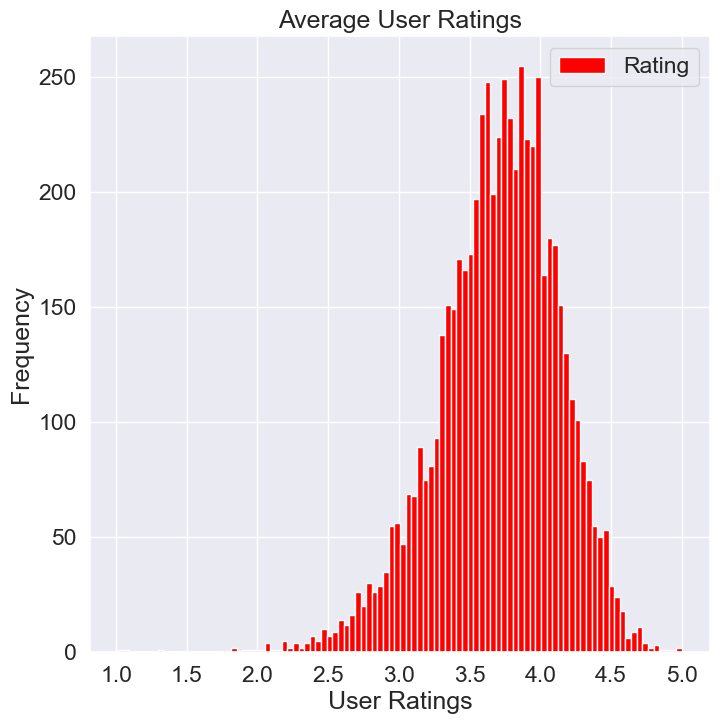

In [104]:
fig = plt.figure(figsize = (8,8))
user_ratings.plot(kind = 'hist', bins = 100, figsize = (8,8), color = 'red')
plt.plot()
plt.xlabel('User Ratings')
plt.title('Average User Ratings')
plt.ylabel('Frequency')

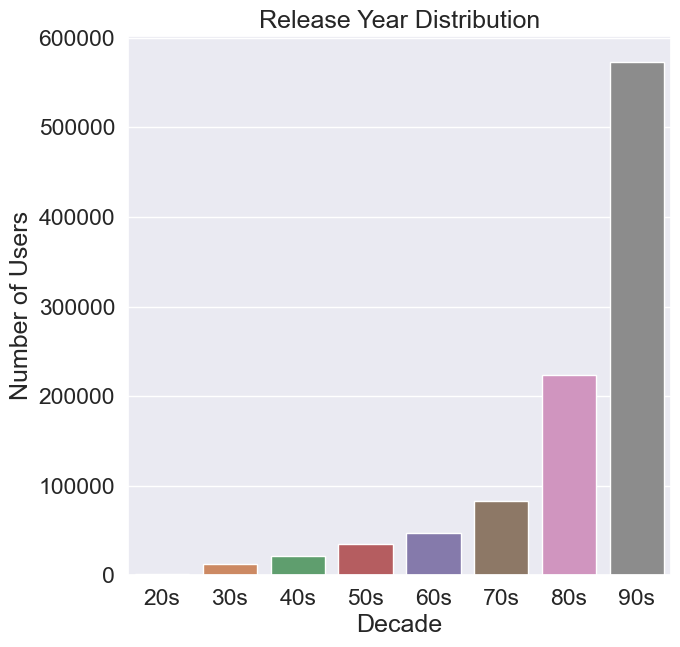

In [105]:
plt.figure(figsize=(7, 7))
sns.countplot(x='ReleaseDec', data=data)
plt.title('Release Year Distribution')
plt.xlabel('Decade')
plt.ylabel('Number of Users')
plt.show()

In [106]:
dfmov['Genres'].apply(pd.Series)

,0,1,2,3,4
0,Animation,Children's,Comedy,NaN,NaN
1,Adventure,Children's,Fantasy,NaN,NaN
2,Comedy,Romance,NaN,NaN,NaN
3,Comedy,Drama,NaN,NaN,NaN
4,Comedy,NaN,NaN,NaN,NaN
...,...,...,...,...,...
3878,Comedy,NaN,NaN,NaN,NaN
3879,Drama,NaN,NaN,NaN,NaN
3880,Drama,NaN,NaN,NaN,NaN
3881,Drama,NaN,NaN,NaN,NaN


In [107]:
(dfmov['Genres'].apply(pd.Series).stack())

0     0     Animation
      1    Children's
      2        Comedy
1     0     Adventure
      1    Children's
              ...    
3879  0         Drama
3880  0         Drama
3881  0         Drama
3882  0         Drama
      1      Thriller
Length: 6335, dtype: object

In [108]:
(dfmov['Genres'].apply(pd.Series).stack()).shape

(6335,)

In [109]:
pd.get_dummies(dfmov['Genres'].apply(pd.Series).stack())

Action  Adventure  Animation  Children's  Comedy  Crime  \
0    0  False   False      False       True       False   False  False   
     1  False   False      False      False        True   False  False   
     2  False   False      False      False       False    True  False   
1    0  False   False       True      False       False   False  False   
     1  False   False      False      False        True   False  False   
...       ...     ...        ...        ...         ...     ...    ...   
3879 0  False   False      False      False       False   False  False   
3880 0  False   False      False      False       False   False  False   
3881 0  False   False      False      False       False   False  False   
3882 0  False   False      False      False       False   False  False   
     1  False   False      False      False       False   False  False   

        Documentary  Drama  Fantasy  Film-Noir  Horror  Musical  Mystery  \
0    0        False  False    False      False   False    False    False   
     1        False  False    False      False   False    False    False   
     2        False  False    False      False   False    False    False   
1    0        False  False    False      False   False    False    False   
     1        False  False    False      False   False    False    False   
...             ...    ...      ...        ...     ...      ...      ...   
3879 0        False   True    False      False   False    False    False   
3880 0        False   True    False      False   False    False    False   
3881 0        False   True    False      False   False    False    False   
3882 0        False   True    False      False   False    False    False   
     1        False  False    False      False   False    False    False   

        Romance  Sci-Fi  Thriller    War  Western  
0    0    False   False     False  False    False  
     1    False   False     False  False    False  
     2    False   False     False  False    False  
1    0    False   False     False  False    False  
     1    False   False     False  False    False  
...         ...     ...       ...    ...      ...  
3879 0    False   False     False  False    False  
3880 0    False   False     False  False    False  
3881 0    False   False     False  False    False  
3882 0    False   False     False  False    False  
     1    False   False      True  False    False  

[6335 rows x 19 columns]

In [110]:
pd.get_dummies(dfmov['Genres'].apply(pd.Series).stack()).shape

(6335, 19)

In [111]:
genres_df = pd.get_dummies(dfmov['Genres'].apply(pd.Series).stack()).astype(int)
genres_df.head()

Action  Adventure  Animation  Children's  Comedy  Crime  Documentary  \
0 0  0       0          0          1           0       0      0            0   
  1  0       0          0          0           1       0      0            0   
  2  0       0          0          0           0       1      0            0   
1 0  0       0          1          0           0       0      0            0   
  1  0       0          0          0           1       0      0            0   

     Drama  Fantasy  Film-Noir  Horror  Musical  Mystery  Romance  Sci-Fi  \
0 0      0        0          0       0        0        0        0       0   
  1      0        0          0       0        0        0        0       0   
  2      0        0          0       0        0        0        0       0   
1 0      0        0          0       0        0        0        0       0   
  1      0        0          0       0        0        0        0       0   

     Thriller  War  Western  
0 0         0    0        0  
  1         0    0        0  
  2         0    0        0  
1 0         0    0        0  
  1         0    0        0

In [112]:
genres_df.sum().iloc[0:]

                  8
Action          501
Adventure       282
Animation       104
Children's      249
Comedy         1189
Crime           210
Documentary     124
Drama          1582
Fantasy          62
Film-Noir        44
Horror          340
Musical         113
Mystery         105
Romance         462
Sci-Fi          265
Thriller        488
War             139
Western          68
dtype: int64

In [113]:
test = genres_df.iloc[:,0:].sum()
test=test.iloc[1:]
print(test)

Action          501
Adventure       282
Animation       104
Children's      249
Comedy         1189
Crime           210
Documentary     124
Drama          1582
Fantasy          62
Film-Noir        44
Horror          340
Musical         113
Mystery         105
Romance         462
Sci-Fi          265
Thriller        488
War             139
Western          68
dtype: int64


In [114]:
test2 = test.to_numpy().reshape(18,)

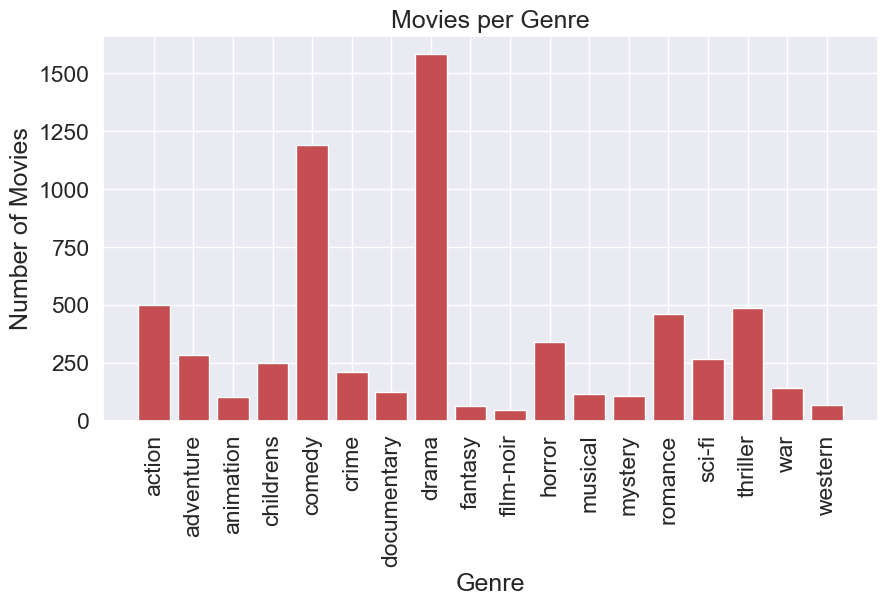

In [115]:
genre_list=['action', 'adventure','animation', 'childrens', 'comedy', 'crime', 'documentary', 'drama','fantasy', 'film-noir', 'horror', 'musical', 'mystery', 'romance', 'sci-fi','thriller', 'war', 'western']
x = np.arange(18)
plt.figure(figsize = (10,5))
plt.bar(x, test2, color = 'r')
plt.xticks(x, genre_list, rotation = 'vertical')
plt.xlabel('Genre')
plt.ylabel('Number of Movies')
plt.title('Movies per Genre')
sns.set(font_scale=1.5)
plt.show()

In [116]:
movies_rating_count = data.groupby(by=['Title'])['Rating'].count().reset_index()[['Title','Rating']]
movies_rating_count.rename(columns = {'Rating' : 'totalRatingCount'},inplace=True)
movies_rating_count.head()

,Title,totalRatingCount
0,"$1,000,000 Duck (1971)",37
1,'Night Mother (1986),70
2,'Til There Was You (1997),52
3,"'burbs, The (1989)",303
4,...And Justice for All (1979),199


In [117]:
top10_movies=movies_rating_count[['Title','totalRatingCount']].sort_values(by='totalRatingCount',ascending=False).head(10)
top10_movies

,Title,totalRatingCount
126,American Beauty (1999),3428
3135,Star Wars: Episode IV - A New Hope (1977),2991
3136,Star Wars: Episode V - The Empire Strikes Back...,2990
3137,Star Wars: Episode VI - Return of the Jedi (1983),2883
1777,Jurassic Park (1993),2672
2877,Saving Private Ryan (1998),2653
3274,Terminator 2: Judgment Day (1991),2649
2098,"Matrix, The (1999)",2590
257,Back to the Future (1985),2583
2972,"Silence of the Lambs, The (1991)",2578


# Recommendation System

In [118]:
matrix = pd.pivot_table(data,index='UserID',columns='Title',values='Rating',aggfunc='mean')

matrix.fillna(0,inplace=True)
matrix.shape

(6040, 3682)

In [120]:
matrix


Title,"$1,000,000 Duck (1971)",'Night Mother (1986),'Til There Was You (1997),"'burbs, The (1989)",...And Justice for All (1979),1-900 (1994),10 Things I Hate About You (1999),101 Dalmatians (1961),101 Dalmatians (1996),12 Angry Men (1957),...,"Young Poisoner's Handbook, The (1995)",Young Sherlock Holmes (1985),Young and Innocent (1937),Your Friends and Neighbors (1998),Zachariah (1971),"Zed & Two Noughts, A (1985)",Zero Effect (1998),Zero Kelvin (Kjærlighetens kjøtere) (1995),Zeus and Roxanne (1997),eXistenZ (1999)
UserID,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
100,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,...,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
996,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,...,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
997,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [121]:
n_users = data['UserID'].nunique()
n_movies = data['MovieID'].nunique()
sparsity = round(1.0 - data.shape[0] / float( n_users * n_movies), 3)
print('The sparsity level of dataset is ' +  str(sparsity * 100) + '%')

The sparsity level of dataset is 95.5%


item item recommendation

In [125]:
data.head()

,MovieID,Title,Genres,Year,UserID,Rating,Timestamp,Gender,Age,Occupation,Zip-code,Datatime,ReleaseDec
0,1,Toy Story (1995),"[Animation, Children's, Comedy]",1995,1,5,978824268,F,Under 18,k-12 student,48067,2001-01-06 23:37:36,90s
1,48,Pocahontas (1995),"[Animation, Children's, Musical, Romance]",1995,1,5,978824351,F,Under 18,k-12 student,48067,2001-01-06 23:38:40,90s
2,150,Apollo 13 (1995),[Drama],1995,1,5,978301777,F,Under 18,k-12 student,48067,2000-12-31 22:29:20,90s
3,260,Star Wars: Episode IV - A New Hope (1977),"[Action, Adventure, Fantasy]",1977,1,4,978300760,F,Under 18,k-12 student,48067,2000-12-31 22:12:16,70s
4,527,Schindler's List (1993),"[Drama, War]",1993,1,5,978824195,F,Under 18,k-12 student,48067,2001-01-06 23:36:32,90s


In [126]:
movie_name = 'Toy Story (1995)'

movie_rating = matrix[movie_name]
movie_rating

UserID
1       5.0
10      5.0
100     0.0
1000    5.0
1001    4.0
       ... 
995     0.0
996     4.0
997     4.0
998     0.0
999     0.0
Name: Toy Story (1995), Length: 6040, dtype: float64

In [127]:
similar_movies = matrix.corrwith(movie_rating)


sim_df = pd.DataFrame(similar_movies, columns=['Correlation'])

sim_df.sort_values('Correlation', ascending=False,inplace=True)

sim_df.iloc[1:, :].head()

,Correlation
Title,
Toy Story 2 (1999),0.487370
Aladdin (1992),0.470753
"Lion King, The (1994)",0.411131
Groundhog Day (1993),0.407547
"Bug's Life, A (1998)",0.402679


In [128]:
item_sim = cosine_similarity(matrix.T)
item_sim


array([[1.        , 0.07235746, 0.03701053, ..., 0.        , 0.12024178,
        0.02700277],
       [0.07235746, 1.        , 0.11528952, ..., 0.        , 0.        ,
        0.07780705],
       [0.03701053, 0.11528952, 1.        , ..., 0.        , 0.04752635,
        0.0632837 ],
       ...,
       [0.        , 0.        , 0.        , ..., 1.        , 0.        ,
        0.04564448],
       [0.12024178, 0.        , 0.04752635, ..., 0.        , 1.        ,
        0.04433508],
       [0.02700277, 0.07780705, 0.0632837 , ..., 0.04564448, 0.04433508,
        1.        ]])

In [129]:
item_sim_matrix = pd.DataFrame(item_sim, index=matrix.columns, columns=matrix.columns)
item_sim_matrix.head()

Title,"$1,000,000 Duck (1971)",'Night Mother (1986),'Til There Was You (1997),"'burbs, The (1989)",...And Justice for All (1979),1-900 (1994),10 Things I Hate About You (1999),101 Dalmatians (1961),101 Dalmatians (1996),12 Angry Men (1957),...,"Young Poisoner's Handbook, The (1995)",Young Sherlock Holmes (1985),Young and Innocent (1937),Your Friends and Neighbors (1998),Zachariah (1971),"Zed & Two Noughts, A (1985)",Zero Effect (1998),Zero Kelvin (Kjærlighetens kjøtere) (1995),Zeus and Roxanne (1997),eXistenZ (1999)
Title,,,,,,,,,,,,,,,,,,,,,
"$1,000,000 Duck (1971)",1.000000,0.072357,0.037011,0.079291,0.060838,0.00000,0.058619,0.189965,0.172254,0.094785,...,0.038725,0.076474,0.000000,0.044074,0.0,0.045280,0.039395,0.000000,0.120242,0.027003
'Night Mother (1986),0.072357,1.000000,0.115290,0.115545,0.159526,0.00000,0.076798,0.147437,0.095922,0.111413,...,0.053010,0.087828,0.063758,0.135962,0.0,0.091150,0.074787,0.000000,0.000000,0.077807
'Til There Was You (1997),0.037011,0.115290,1.000000,0.098756,0.066301,0.08025,0.127895,0.112654,0.125670,0.079115,...,0.029200,0.062893,0.000000,0.079187,0.0,0.022594,0.079261,0.000000,0.047526,0.063284
"'burbs, The (1989)",0.079291,0.115545,0.098756,1.000000,0.143620,0.00000,0.192191,0.246927,0.175885,0.170719,...,0.113386,0.207897,0.019962,0.138064,0.0,0.055704,0.161174,0.000000,0.033567,0.110525
...And Justice for All (1979),0.060838,0.159526,0.066301,0.143620,1.000000,0.00000,0.075093,0.194154,0.116379,0.205486,...,0.089998,0.153006,0.067009,0.109029,0.0,0.086080,0.110867,0.074317,0.000000,0.111040


User User Similarity

In [130]:
user_sim = cosine_similarity(matrix)
user_sim

array([[1.        , 0.25586725, 0.12396703, ..., 0.15926709, 0.11935626,
        0.12205855],
       [0.25586725, 1.        , 0.25863269, ..., 0.16071024, 0.13280705,
        0.24681021],
       [0.12396703, 0.25863269, 1.        , ..., 0.20430203, 0.11352239,
        0.30610356],
       ...,
       [0.15926709, 0.16071024, 0.20430203, ..., 1.        , 0.18657496,
        0.18245166],
       [0.11935626, 0.13280705, 0.11352239, ..., 0.18657496, 1.        ,
        0.10797727],
       [0.12205855, 0.24681021, 0.30610356, ..., 0.18245166, 0.10797727,
        1.        ]])

In [131]:
user_sim_matrix = pd.DataFrame(user_sim, index=matrix.index, columns=matrix.index)
user_sim_matrix.head()

UserID,1,10,100,1000,1001,1002,1003,1004,1005,1006,...,990,991,992,993,994,995,996,997,998,999
UserID,,,,,,,,,,,,,,,,,,,,,
1,1.000000,0.255867,0.123967,0.207800,0.139266,0.110320,0.121384,0.179293,0.103896,0.052816,...,0.079367,0.038048,0.032136,0.066641,0.070052,0.035731,0.170184,0.159267,0.119356,0.122059
10,0.255867,1.000000,0.258633,0.279386,0.155439,0.112477,0.141431,0.429555,0.190388,0.102088,...,0.153811,0.186509,0.083413,0.123568,0.118096,0.145981,0.300856,0.160710,0.132807,0.246810
100,0.123967,0.258633,1.000000,0.297539,0.075708,0.110450,0.358686,0.236263,0.172872,0.099147,...,0.098235,0.097953,0.065152,0.176048,0.271311,0.033754,0.344290,0.204302,0.113522,0.306104
1000,0.207800,0.279386,0.297539,1.000000,0.094849,0.047677,0.201722,0.354078,0.325966,0.130702,...,0.170100,0.076779,0.000000,0.197410,0.380741,0.044404,0.330748,0.172803,0.098456,0.245292
1001,0.139266,0.155439,0.075708,0.094849,1.000000,0.164793,0.053867,0.149363,0.138551,0.134660,...,0.146216,0.026881,0.096975,0.117815,0.092201,0.109660,0.222037,0.100745,0.269852,0.175451


In [132]:
user_sim_matrix = pd.DataFrame(user_sim, index=matrix.index, columns=matrix.index)
user_sim_matrix.head()

UserID,1,10,100,1000,1001,1002,1003,1004,1005,1006,...,990,991,992,993,994,995,996,997,998,999
UserID,,,,,,,,,,,,,,,,,,,,,
1,1.000000,0.255867,0.123967,0.207800,0.139266,0.110320,0.121384,0.179293,0.103896,0.052816,...,0.079367,0.038048,0.032136,0.066641,0.070052,0.035731,0.170184,0.159267,0.119356,0.122059
10,0.255867,1.000000,0.258633,0.279386,0.155439,0.112477,0.141431,0.429555,0.190388,0.102088,...,0.153811,0.186509,0.083413,0.123568,0.118096,0.145981,0.300856,0.160710,0.132807,0.246810
100,0.123967,0.258633,1.000000,0.297539,0.075708,0.110450,0.358686,0.236263,0.172872,0.099147,...,0.098235,0.097953,0.065152,0.176048,0.271311,0.033754,0.344290,0.204302,0.113522,0.306104
1000,0.207800,0.279386,0.297539,1.000000,0.094849,0.047677,0.201722,0.354078,0.325966,0.130702,...,0.170100,0.076779,0.000000,0.197410,0.380741,0.044404,0.330748,0.172803,0.098456,0.245292
1001,0.139266,0.155439,0.075708,0.094849,1.000000,0.164793,0.053867,0.149363,0.138551,0.134660,...,0.146216,0.026881,0.096975,0.117815,0.092201,0.109660,0.222037,0.100745,0.269852,0.175451


In [134]:
model_knn = NearestNeighbors(metric='cosine')
model_knn.fit(matrix.T)

NearestNeighbors(metric='cosine')

In [135]:
distances, indices = model_knn.kneighbors(matrix.T,n_neighbors=6)

In [136]:
result = pd.DataFrame(indices, columns=['Title1','Title2','Title3', 'Title4', 'Title5', 'Title6'])

result.head()

,Title1,Title2,Title3,Title4,Title5,Title6
0,0,738,418,288,3283,586
1,1,810,73,2193,3072,3408
2,2,1642,2561,3359,2620,2021
3,3,1471,2195,1317,1053,3552
4,4,27,729,897,497,948


In [137]:
result2 = result.copy()
for i in range(1, 7):
    mov = pd.DataFrame(matrix.T.index).reset_index()
    mov = mov.rename(columns={'index':f'Title{i}'})
    result2 = pd.merge(result2, mov, on=[f'Title{i}'], how='left')
    result2 = result2.drop(f'Title{i}', axis=1)
    result2 = result2.rename(columns={'Title':f'Title{i}'})
result2.head()

,Title1,Title2,Title3,Title4,Title5,Title6
0,"$1,000,000 Duck (1971)","Computer Wore Tennis Shoes, The (1970)",Blackbeard's Ghost (1968),"Barefoot Executive, The (1971)",That Darn Cat! (1965),Candleshoe (1977)
1,'Night Mother (1986),"Cry in the Dark, A (1988)",Agnes of God (1985),Mommie Dearest (1981),Sophie's Choice (1982),"Trip to Bountiful, The (1985)"
2,'Til There Was You (1997),If Lucy Fell (1996),Picture Perfect (1997),To Gillian on Her 37th Birthday (1996),Practical Magic (1998),Mad Love (1995)
3,"'burbs, The (1989)",Harry and the Hendersons (1987),"Money Pit, The (1986)",Ghostbusters II (1989),European Vacation (1985),Weekend at Bernie's (1989)
4,...And Justice for All (1979),52 Pick-Up (1986),Coma (1978),Deliverance (1972),"Boys from Brazil, The (1978)",Dog Day Afternoon (1975)


In [139]:
movie_name = 'Toy Story (1995)'

result2.loc[result2['Title1']==movie_name] 

,Title1,Title2,Title3,Title4,Title5,Title6
3390,Toy Story (1995),Toy Story 2 (1999),Groundhog Day (1993),Aladdin (1992),"Bug's Life, A (1998)",Back to the Future (1985)


Matrix Factorization


In [140]:
rm = data.pivot(index= 'UserID', columns= 'MovieID', values = 'Rating').fillna(0)
rm.head()

MovieID,1,10,100,1000,1002,1003,1004,1005,1006,1007,...,99,990,991,992,993,994,996,997,998,999
UserID,,,,,,,,,,,,,,,,,,,,,
1,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
100,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1000,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1001,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [141]:
user_itm = data[['UserID', 'MovieID', 'Rating']].copy()
user_itm.columns = ['UserId', 'ItemId', 'Rating']

user_itm.head(2)

,UserId,ItemId,Rating
0,1,1,5
1,1,48,5


In [ ]:
# !pip install cmfrec
from cmfrec import CMF

In [ ]:
model = CMF(method="als",k=4,lambda_=0.1,user_bias=False,item_bias=False,verbose=True)
model.fit(user_itm)

In [ ]:
model.A_.shape, model.B_.shape

# represting our matrix 1 and matrix 2

In [ ]:
user_itm.Rating.mean(), model.glob_mean_#average rating and globalmean 

In [ ]:
rm__ = np.dot(model.A_, model.B_.T) + model.glob_mean_ 

In [ ]:
rmse = mean_squared_error(rm.values[rm > 0], rm__[rm > 0], squared=False) # Calculating rmse value
print('Root Mean Squared Error : {:.3f}'.format(rmse))

the corresponding error is 1.145 which is decent


In [ ]:
# ?embedding for user user cosine_similarity
user=cosine_similarity(model.A_)

user_sim_matrix=pd.DataFrame(user,index=matrix.index,columns=matrix.index)
user_sim_matrix.head()

In [ ]:
# ?embedding for item item similarity
itm=cosine_similarity(model.B_)

itm_sim_matrix=pd.DataFrame(itm,index=user_itm['ItemId'].unique(),columns=user_itm['ItemId'].unique())
itm_sim_matrix.head()

In [ ]:
# it is another type of example of dimensionallity reduction 
# wherewe reduce the dimensionallity now we can again apply our previous method to get the recommendation 
# it will reduce our computational time 
# and also reduce the cost

In [ ]:

movie_rating=itm_sim_matrix[movie_name]

In [ ]:
similar_movies=itm_sim_matrix.corrwith(movie_rating)
sim_df=pd.DataFrame(similar_movies,columns=['Correlation'])
sim_df.sort_values('Correlation',ascending=False,inplace=True)

In [ ]:
item_mov=data[['MovieID','Title']].copy()
item_mov.drop_duplicates(inplace=True)
item_mov.reset_index(drop=True,inplace=True)

sim_df1=sim_df.copy()
sim_df1.reset_index(inplace=True)
sim_df1.rename(columns={'index':'MovieID'},inplace=True)
sim_mov=pd.merge(sim_df1,item_mov,on='MovieID',how='inner')
sim_mov.head(6)

In [ ]:
# using surprise library also we can achieve thee 

Popularity based Recommendatuion


In [145]:
movie_data=pd.merge(ratings,movies,on='MovieID')

In [ ]:
movie_data.groupby('Title')['Rating'].mean().sort_values(ascending=False)

In [150]:
rating_mean=pd.DataFrame(movie_data.groupby('Title')['Rating'].mean())

In [151]:
rating_mean['rating_count']=pd.DataFrame(movie_data.groupby('Title')['Rating'].count())

In [ ]:
rating_mean